# Insights into Lending Risks


## Importing necessary libraries


In [1]:

import os
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import spacy

In [2]:
# Setting display options for better visibility of data
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

In [3]:
# consents
# Define categories and their associated keywords
# fmt: off
EMP_CATEGORY_KEYWORDS = {
    "government": [ "us government", "federal government", "state government", "local government", 
                   "us army", "us air force", "us navy", "usmc", "department of defense", "department of homeland security", 
                   "department of veterans affairs", "internal revenue service", "united states air force", "military", "nypd", 
                   "faa", "railroad", "Rail", "Los Angeles County", "Southern California Edison", "FBI", "NASA",
    ],
    "company": [ "ibm", "microsoft", "cisco systems", "hewlett packard", "intel", "apple", "google", 
                "amazon", "oracle", "vmware", "adobe", "salesforce", "dell", "csc", "adp", "siemens", 
                "fiserv", "saic", "honeywell", "fedex", "ups", "KPMG", "Ernst Young", "Booz Allen Hamilton", 
                "Accenture", "Waste Management", "Bechtel", "URS", "Adecco", "Cargill", "Sodexo", "Compass Group", 
                "HP", "Autozone", "Aerotek", "CenturyLink", "Deloitte", "Jacobs Engineering", "Turner Broadcasting", 
                "Madison Square Garden", "RR Donnelley", "Quest Diagnostics", "Xerox", "Sherwin Williams", "Halliburton", 
                "Staples", "Walt Disney World", "New York Life", "LLP", "Technology Solutions", 'PwC', 'Capgemini',
    ],
    "financial": [ "bank of america", "wells fargo", "jp morgan chase", "citi bank", "chase bank", "morgan stanley", 
                  "merrill lynch", "fidelity investments", "bny mellon", "edward jones", "hsbc", "charles schwab", 
                  "Goldman Sachs", "Thomson Reuters", "The Hartford", "Progressive Insurance", "Travelers Insurance", 
                  "Credit Suisse", "TIAA CREF", "Capital One", "GEICO", "Barclays Capital", "Northwestern Mutual", "BBT", 
                  "UBS", "Prudential", "Fannie Mae",
    ],
    "retail": [ "walmart", "target", "sears", "aramark", "best buy", "home depot", "lowes", "walgreens", 
               "macys", "costco", "whole foods market", "gap", "conocophillips", "johnson johnson", "general electric", 
               "Nordstrom", "Frito Lay", "Rite Aid", "Starbucks", "Trader Joes", "Trader Joes", "Kroger", "Staples",
    ],
    "healthcare": [ "kaiser permanente", "cvs pharmacy", "pfizer", "upmc", "AIG", "Cardinal Health", "MetLife", "Cardinal Health", 
                   "MetLife", "Memorial Sloan-Kettering Cancer Center", "Mayo Clinic", "Aetna", "Quest Diagnostics", "Hospital" ],
    "telecom": [ "verizon", "at", "mobile", "sprint", "time warner cable", "verizon wireless", "Comcast", "Century Link",],
    "aerospace": ["boeing", "lockheed martin", "northrop grumman", "raytheon", "bae systems"],
    "university": ["columbia university", "student", "School", "UCLA", "College"],
    "self employed": ["self", "self-employed", "self employed"],
    "unemployed": ["retired", "unemployed"],
}
# fmt: on

EMP_TITLE_CATEGORY = dict()

NLP_lg = None
try:
    NLP_lg = spacy.load("en_core_web_lg")
except OSError:
    import spacy.cli

    spacy.cli.download("en_core_web_lg")
    NLP_lg = spacy.load("en_core_web_lg")

## Methods

In [4]:
# Data Visualization methods
def visualize_distribution_minimal(df, categorical_col):
    """
        Visualizes the distribution of a categorical column with minimal colors and value labels.
    """
    # Ensure order is a list of category labels
    order = sorted(df[categorical_col].unique())
    
    # Visualize the distribution using a bar plot with minimal colors
    plt.figure(figsize=(10, 6))
    counts = df[categorical_col].value_counts().sort_index()  # Get category counts
    sns.countplot(
        x=categorical_col,
        data=df,
        hue=categorical_col,
        palette="Set2",
        order= order,
        legend=False
    )
    
    # Add value labels on top of each bar
    for i, (cat, count) in enumerate(counts.items()):
        plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=12)
    
    plt.title(f"Distribution of {categorical_col.replace('_', ' ').capitalize()}")
    plt.xlabel(categorical_col.replace('_', ' ').capitalize())
    plt.ylabel("Count")
    plt.xticks(rotation=45)

    # Customize grid and labels for a cleaner look
    plt.tight_layout()  # Adjust spacing for better readability

    plt.show()

In [5]:
# Data Processing Methods
def categorize_emp_length(emp_length: str):
    """
    Categorizes employment length into specific bins.
    """
    emp_length = emp_length.lower().strip()

    if emp_length in ["0 year", "0 years", "< 1 year", "1 year"]:
        return "<= 1 year"

    if emp_length in ["2 years", "3 years", "4 years", "5 years"]:
        return "<= 5 years"

    if emp_length in ["6 years", "7 years", "8 years", "9 years"]:
        return "<= 9 years"

    if emp_length in ["10 years", "> 10 years", "10+ years"]:
        return ">= 10 years"

    return "unknown"


def categorize_employer(employer_title: str) -> str:
    """
    Categorizes an employer title into predefined categories.
    """
    if employer_title in EMP_TITLE_CATEGORY:
        return EMP_TITLE_CATEGORY[employer_title]
    # Processes text by removing non-alphanumeric characters and converting to lowercase.
    clean_text = lambda text: (
        re.sub(r"\W+", "", text.lower().strip()) if re.sub(r"\W+", "", text.lower().strip()) != "" else text
    )

    # Preprocess the input employer title
    employer_title_cleaned = clean_text(employer_title)

    if employer_title_cleaned in EMP_TITLE_CATEGORY:
        return EMP_TITLE_CATEGORY[employer_title_cleaned]

    # Categorize the employer
    for category, keywords in EMP_CATEGORY_KEYWORDS.items():
        cleaned_category = clean_text(category)
        for keyword in keywords:
            if employer_title_cleaned in clean_text(keyword):
                EMP_TITLE_CATEGORY[employer_title] = category
                EMP_TITLE_CATEGORY[employer_title_cleaned] = category
                return category
            for word in keyword.split():
                if clean_text(word) in employer_title_cleaned:
                    EMP_TITLE_CATEGORY[employer_title] = category
                    EMP_TITLE_CATEGORY[word] = category
                    return category
        if cleaned_category in employer_title_cleaned:
            return category
    
    try:
        for ent in NLP_lg(employer_title).ents:
            if ent.label_ == "MONEY":
                EMP_TITLE_CATEGORY[employer_title] = "financial"
                return "financial"
            if ent.label_ == "ORG":
                EMP_TITLE_CATEGORY[employer_title] = "company"
                return "company"
            if ent.label_ == "GPE":
                EMP_TITLE_CATEGORY[employer_title] = "government"
                return "government"
    except:
        pass
    return "unknown"

## Loading datasets


In [6]:
# Replace 'path_to_file' with the actual path to the files
current_dir = %pwd
data_dir = os.path.join(current_dir, '..', 'data', 'raw')
loan_data_path = os.path.join(data_dir, 'loan.csv')

In [7]:
# Loading loan data
try:
    loan_df_raw: pd.DataFrame = pd.read_csv(loan_data_path, low_memory=False, sep=',')
    print(f"Loan data loaded successfully. Shape: {loan_df_raw.shape}")
except FileNotFoundError:
    print("Error: loan.csv file not found. Please check the file path.")

Loan data loaded successfully. Shape: (39717, 111)


In [8]:
# Displaying first few rows of the dataset
print("\nFirst 5 rows of the loan data:")
display(loan_df_raw.head())


First 5 rows of the loan data:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,4975.0,36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,2500.0,60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,2400.0,36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,10000.0,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21%,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [9]:
# Displaying column information
print("\nDataset Information:")
loan_df_raw.info()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


In [10]:
# Displaying descriptive statistics for numeric columns
print("\nDescriptive Statistics for Numeric Columns:")
display(loan_df_raw.describe())


Descriptive Statistics for Numeric Columns:


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,14035.000000,2786.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39661.0,0.0,39717.0,0.0,0.0,0.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39661.0,39717.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,35.900962,69.698134,9.294408,0.055065,13382.528086,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2678.826162,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,22.020060,43.822529,4.400282,0.237200,15885.016641,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,4447.136012,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,18.000000,22.000000,6.000000,0.000000,3703.000000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,218.680000,0.0,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [11]:
# Checking for missing values
print("\nMissing Values in Each Column:")
missing_values = loan_df_raw.isnull().sum().sort_values(ascending=False)
print(missing_values[missing_values > 0])  # Display only columns with missing values


Missing Values in Each Column:
num_il_tl                         39717
num_bc_sats                       39717
num_bc_tl                         39717
num_actv_bc_tl                    39717
num_accts_ever_120_pd             39717
mths_since_recent_revol_delinq    39717
num_actv_rev_tl                   39717
mths_since_recent_inq             39717
num_tl_90g_dpd_24m                39717
num_tl_30dpd                      39717
num_tl_120dpd_2m                  39717
num_sats                          39717
num_rev_tl_bal_gt_0               39717
num_rev_accts                     39717
pct_tl_nvr_dlq                    39717
mo_sin_old_il_acct                39717
mo_sin_old_rev_tl_op              39717
mo_sin_rcnt_rev_tl_op             39717
mo_sin_rcnt_tl                    39717
mths_since_recent_bc              39717
mort_acc                          39717
mths_since_recent_bc_dlq          39717
bc_util                           39717
total_rev_hi_lim                  39717
all_util

In [12]:
# Checking for duplicate rows
duplicates = loan_df_raw.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


### 📈 Data Understanding Summary

**Dataset Overview:**

`loan.csv` dataset is a comprehensive record of 39,717 loans. It consists of 111 columns, primarily numeric (74 float64, 13 int64) with a smaller portion of categorical data (24 object).

**Key Observations:**

1. **Unique Identifiers: 💡**

   - `id` and `member_id`, these columns seem to be unique identifiers.

2. **Loan Amount and Funding: 💰**

   - Principal loan amount (`loan_amnt`) ranges from $500(min) to $35,000(max), with an average $11,219.
   - Funded amounts (`funded_amnt` and `funded_amnt_inv`) closely mirror loan amount, indicating successful funding.

3. **Installment Payments: 📆**

   - Monthly payment amount (`installment`) ranges from $15.69(min) to $1,305.19(max), with an average $324.56.

4. **Income and Debt:**

   - Annual income (`annual_inc`) averages around $68,968. However, presence of outliers, such as a max value is of $6 million, suggests potential data entry errors or exceptional cases.
   - Debt-to-income ratio (`dti`) averages 13.32%, with max of 29.99%, which is reasonable for lending scenarios.

5. **Credit History: 💳**

   - Average number of _Open credit accounts_ (`open_acc`) is 9.29.
   - Average number of _Total credit accounts_ (`total_acc`) is 22.09.
   - Average revolving balance (`revol_bal`) is $13,382, with a max of $149,588.

6. **Payment and Recovery: 💵**

   - Total payment amount (`total_pymnt`) averages around $12,153, slightly exceeding average loan amount.
   - Recovery amount (`recoveries`) averages around $95.22, reflecting funds recovered from defaulted loans.

7. **Missing Data: ⚠️**
   - Several columns, such as `mths_since_last_delinq`, `mths_since_last_record`, and `annual_inc_joint`, have significant missing data, indicating potential data collection limitations.

   **Data Quality Concerns/ observations:**

   - Outliers exist in columns like `annual_inc` and `revol_bal`.
   - Columns like `policy_code` contain mostly a 1-2/single value or NaN, offering min variance.
   - Columns like `zip_code` is having incomplete data we will continue with `addr_state`
   - Columns like `collections_12_mths_ex_med`, `chargeoff_within_12_mths`, `tax_liens`, `acc_now_delinq`, `delinq_amnt` has value 1/single value (predominately 0) or NaN, invalid or error-pron data.


### 🧹 Data Cleaning and Manipulation

In [13]:
# Check for missing values
# Set a threshold for significant missing values
missing_value_threshold = 90 # After experimenting with multiple values concluded to look for more then 90%

# Calculate missing values as a percentage
missing_values_percentage = loan_df_raw.isnull().sum() * 100 / len(loan_df_raw)

# Filter columns with missing values exceeding the threshold
columns_with_high_missing_values = missing_values_percentage[missing_values_percentage > missing_value_threshold]

# Print the results in a clear and concise format
print("Columns with missing values exceeding the threshold of {}%:\n".format(missing_value_threshold))
print(columns_with_high_missing_values)

Columns with missing values exceeding the threshold of 90%:

mths_since_last_record             92.985372
next_pymnt_d                       97.129693
mths_since_last_major_derog       100.000000
annual_inc_joint                  100.000000
dti_joint                         100.000000
verification_status_joint         100.000000
tot_coll_amt                      100.000000
tot_cur_bal                       100.000000
open_acc_6m                       100.000000
open_il_6m                        100.000000
open_il_12m                       100.000000
open_il_24m                       100.000000
mths_since_rcnt_il                100.000000
total_bal_il                      100.000000
il_util                           100.000000
open_rv_12m                       100.000000
open_rv_24m                       100.000000
max_bal_bc                        100.000000
all_util                          100.000000
total_rev_hi_lim                  100.000000
inq_fi                            100.0

#### 🔍Handle missing values

In [14]:
# Drop unnecessary columns

# Let's get rid of those columns that don't tell us anything interesting 🗑️.
columns_to_drop = ['id', 'member_id', # dropping user identifier as they are note relevant for analysis 
                   'url', 'desc', # Static text data
                   'zip_code', # zip code has issue where it's not complete we will continue with `addr_state`
                   'policy_code', # As per understanding of business and data dropping
                   'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'tax_liens', 'acc_now_delinq', 'delinq_amnt']
loan_clean_df = loan_df_raw.drop(columns=columns_to_drop)

# After experimenting with multiple values concluded to look for more then 90%
# Set a threshold for dropping columns with high missing values (90% in this case)
# Calculate the minimum number of non-missing values required per column
min_non_missing_values = int(0.9 * len(loan_clean_df))

# Drop columns with more missing values than the threshold
loan_clean_df.dropna(thresh=min_non_missing_values, axis=1, inplace=True)

In [15]:
# Basic info about the dataset
print("Dataset Info:")
loan_clean_df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 43 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   loan_amnt                39717 non-null  int64  
 1   funded_amnt              39717 non-null  int64  
 2   funded_amnt_inv          39717 non-null  float64
 3   term                     39717 non-null  object 
 4   int_rate                 39717 non-null  object 
 5   installment              39717 non-null  float64
 6   grade                    39717 non-null  object 
 7   sub_grade                39717 non-null  object 
 8   emp_title                37258 non-null  object 
 9   emp_length               38642 non-null  object 
 10  home_ownership           39717 non-null  object 
 11  annual_inc               39717 non-null  float64
 12  verification_status      39717 non-null  object 
 13  issue_d                  39717 non-null  object 
 14  loan_sta

In [16]:
# Convert data types
loan_clean_df['term'] = loan_clean_df['term'].str.extract('(\d+)').astype(int)  # Extract numeric values from strings

# Convert relevant columns to float format
float_columns = ['int_rate', 'revol_util']
for col in float_columns:
    loan_clean_df[col] = loan_clean_df[col].str.replace('%', '').astype(float)

# Convert relevant columns to datetime format
loan_clean_df['last_pymnt_d'] = loan_clean_df['last_pymnt_d'].fillna('Nov-24') # Data imputed as 'Nov-24'
loan_clean_df['last_credit_pull_d'] = loan_clean_df['last_credit_pull_d'].fillna('Nov-24') # Data imputed as 'Nov-24'

date_columns = ['issue_d', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']
for col in date_columns:
    loan_clean_df[col] = pd.to_datetime(loan_clean_df[col], format='%b-%y', errors='coerce')

# Impute remaining missing values
loan_clean_df['title'] = loan_clean_df['title'].fillna(loan_clean_df['title'].mode()[0])  # Fill with mode
loan_clean_df['emp_title'] = loan_clean_df['emp_title'].fillna('Unknown')  # Categorical imputation
loan_clean_df['emp_length'] = loan_clean_df['emp_length'].fillna('0 years')  # Fill with default category

loan_clean_df['annual_inc'] = loan_clean_df['annual_inc'].fillna(loan_clean_df['annual_inc'].median())  # Median for numerical column
loan_clean_df['revol_util'] = loan_clean_df['revol_util'].fillna(loan_clean_df['revol_util'].median())  # Median imputation for numeric

loan_clean_df['pub_rec_bankruptcies'] = loan_clean_df['pub_rec_bankruptcies'].fillna(0)  # Treat missing as 0



In [17]:
# Verify remaining missing values
print("\nRemaining Missing Values:")
print(loan_clean_df.isnull().sum())


Remaining Missing Values:
loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
grade                      0
sub_grade                  0
emp_title                  0
emp_length                 0
home_ownership             0
annual_inc                 0
verification_status        0
issue_d                    0
loan_status                0
pymnt_plan                 0
purpose                    0
title                      0
addr_state                 0
dti                        0
delinq_2yrs                0
earliest_cr_line           0
inq_last_6mths             0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
initial_list_status        0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp 

In [18]:
# Displaying first few rows of the dataset
print("\nFirst 5 rows of the loan data: (After processing)")
loan_clean_df.head()


First 5 rows of the loan data: (After processing)


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,title,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,application_type,pub_rec_bankruptcies
0,5000,5000,4975.0,36,10.65,162.87,B,B2,Unknown,10+ years,RENT,24000.0,Verified,2011-12-01,Fully Paid,n,credit_card,Computer,AZ,27.65,0,1985-01-01,1,3,0,13648,83.7,9,f,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.00,0.00,2015-01-01,171.62,2016-05-01,INDIVIDUAL,0.0
1,2500,2500,2500.0,60,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,2011-12-01,Charged Off,n,car,bike,GA,1.00,0,1999-04-01,5,3,0,1687,9.4,4,f,0.00,0.00,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,2013-04-01,119.66,2013-09-01,INDIVIDUAL,0.0
2,2400,2400,2400.0,36,15.96,84.33,C,C5,Unknown,10+ years,RENT,12252.0,Not Verified,2011-12-01,Fully Paid,n,small_business,real estate business,IL,8.72,0,2001-11-01,2,2,0,2956,98.5,10,f,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.00,0.00,2014-06-01,649.91,2016-05-01,INDIVIDUAL,0.0
3,10000,10000,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,2011-12-01,Fully Paid,n,other,personel,CA,20.00,0,1996-02-01,1,10,0,5598,21.0,37,f,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.00,0.00,2015-01-01,357.48,2016-04-01,INDIVIDUAL,0.0
4,3000,3000,3000.0,60,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,2011-12-01,Current,n,other,Personal,OR,17.94,0,1996-01-01,0,15,0,27783,53.9,38,f,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.00,0.00,2016-05-01,67.79,2016-05-01,INDIVIDUAL,0.0


In [19]:
categorical_cols = loan_clean_df.select_dtypes(include=['object']).columns.tolist()
print("\nFirst 5 rows of the loan data: (After processing)[only object type]")
loan_clean_df[categorical_cols].head()


First 5 rows of the loan data: (After processing)[only object type]


,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,loan_status,pymnt_plan,purpose,title,addr_state,initial_list_status,application_type
0,B,B2,Unknown,10+ years,RENT,Verified,Fully Paid,n,credit_card,Computer,AZ,f,INDIVIDUAL
1,C,C4,Ryder,< 1 year,RENT,Source Verified,Charged Off,n,car,bike,GA,f,INDIVIDUAL
2,C,C5,Unknown,10+ years,RENT,Not Verified,Fully Paid,n,small_business,real estate business,IL,f,INDIVIDUAL
3,C,C1,AIR RESOURCES BOARD,10+ years,RENT,Source Verified,Fully Paid,n,other,personel,CA,f,INDIVIDUAL
4,B,B5,University Medical Group,1 year,RENT,Source Verified,Current,n,other,Personal,OR,f,INDIVIDUAL


### 🐱‍👤Data analysis

Column: grade
grade
B    12020
A    10085
C     8098
D     5307
E     2842
F     1049
G      316
Name: count, dtype: int64



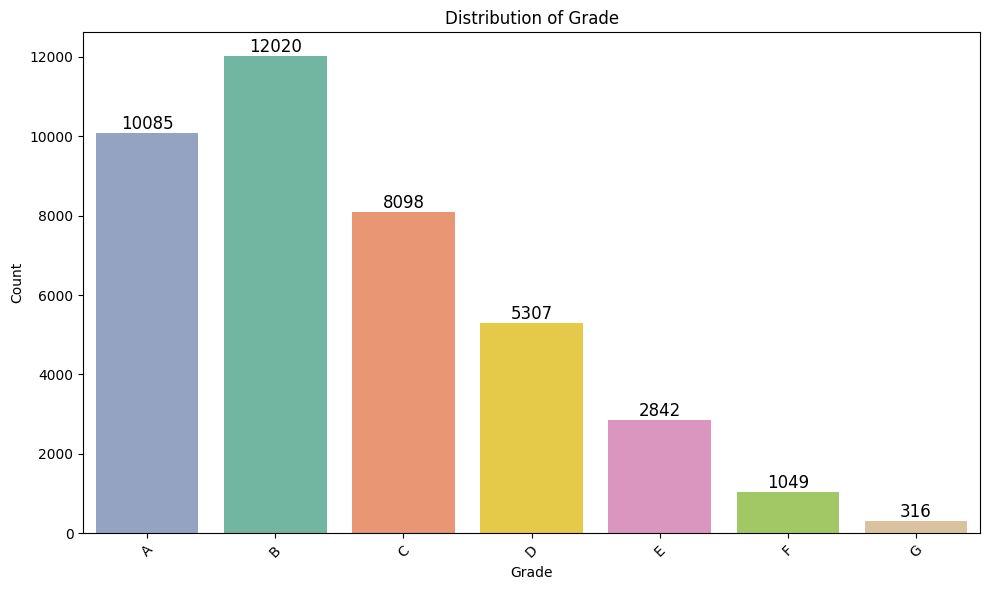

Column: sub_grade
sub_grade
B3    2917
A4    2886
A5    2742
B5    2704
B4    2512
C1    2136
B2    2057
C2    2011
B1    1830
A3    1810
C3    1529
A2    1508
D2    1348
C4    1236
C5    1186
D3    1173
A1    1139
D4     981
D1     931
D5     874
E1     763
E2     656
E3     553
E4     454
E5     416
F1     329
F2     249
F3     185
F4     168
F5     118
G1     104
G2      78
G4      56
G3      48
G5      30
Name: count, dtype: int64



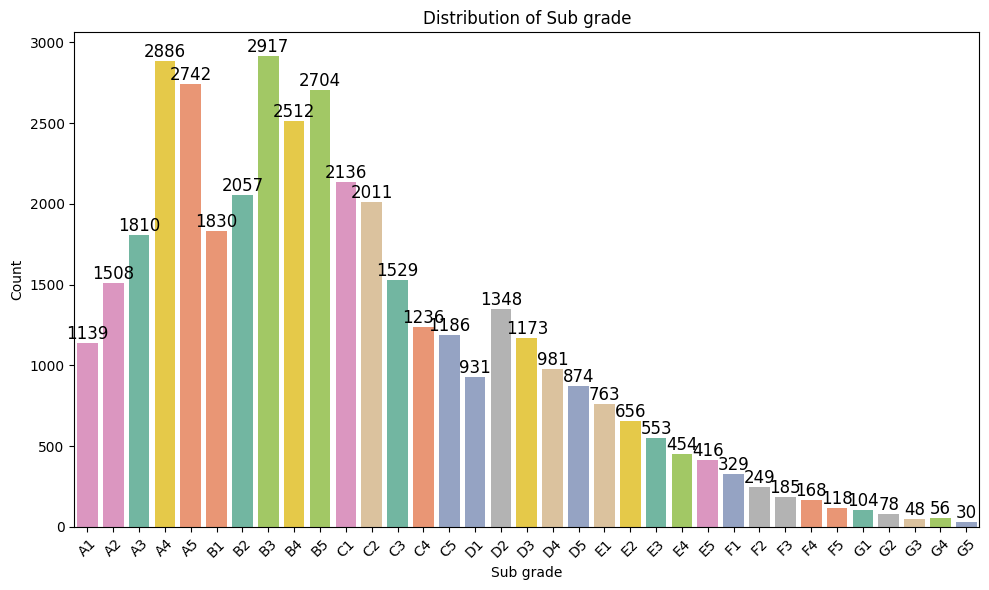

Column: emp_title
emp_title
Unknown                     2459
US Army                      134
Bank of America              109
IBM                           66
AT&T                          59
                            ... 
Stratagem, Inc.                1
Panavision International       1
Duracell                       1
Chin's Restaurant              1
Internal revenue Service       1
Name: count, Length: 28821, dtype: int64

Column: emp_length
emp_length
10+ years    8879
< 1 year     4583
2 years      4388
3 years      4095
4 years      3436
5 years      3282
1 year       3240
6 years      2229
7 years      1773
8 years      1479
9 years      1258
0 years      1075
Name: count, dtype: int64



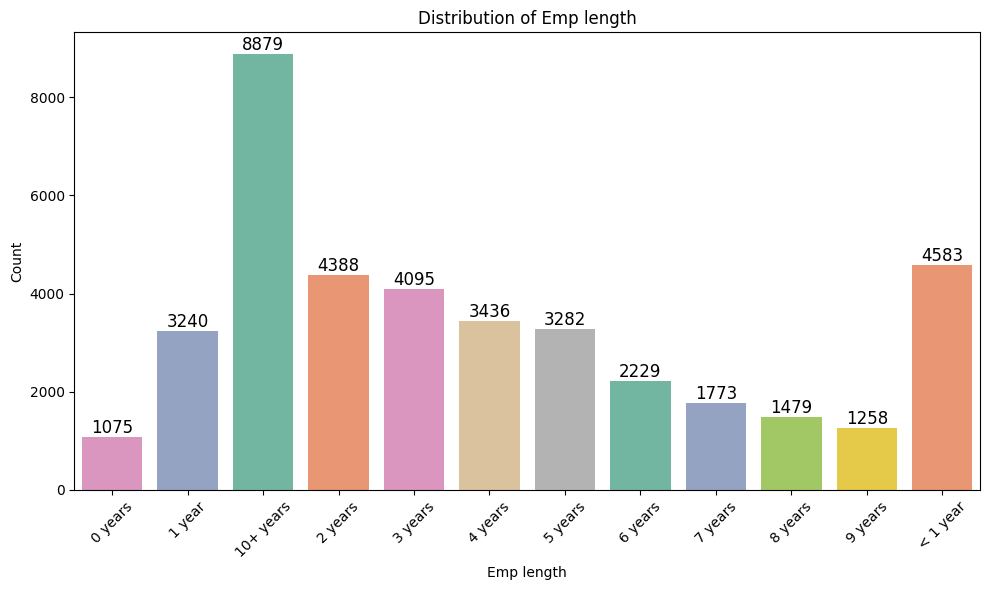

Column: home_ownership
home_ownership
RENT        18899
MORTGAGE    17659
OWN          3058
OTHER          98
NONE            3
Name: count, dtype: int64



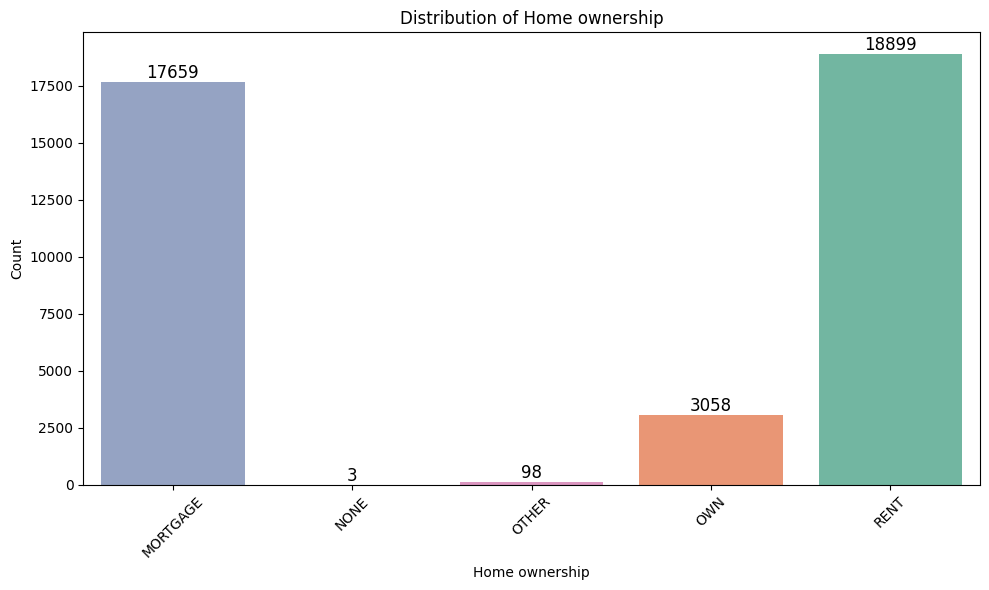

Column: verification_status
verification_status
Not Verified       16921
Verified           12809
Source Verified     9987
Name: count, dtype: int64



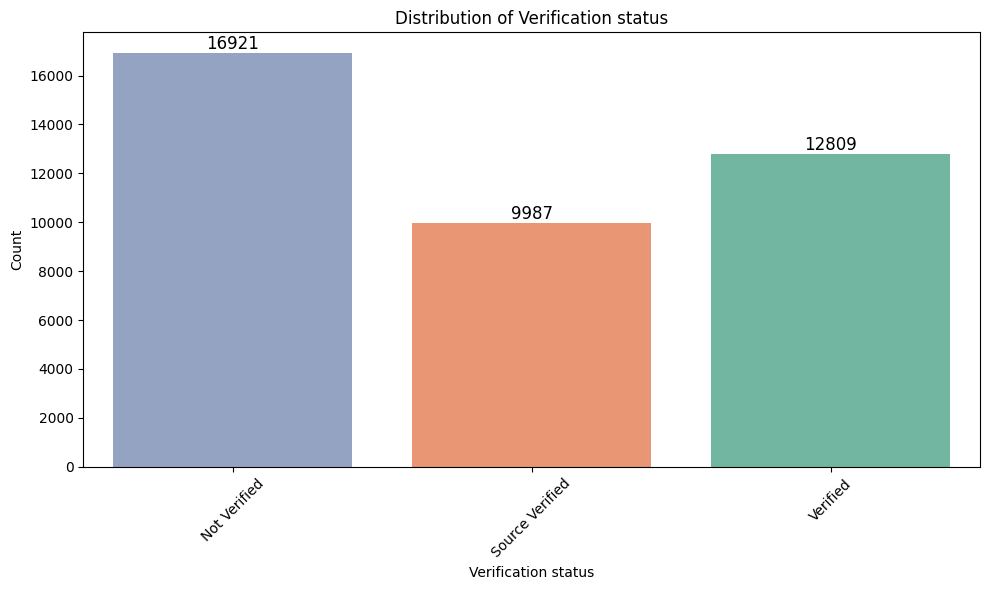

Column: loan_status
loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64



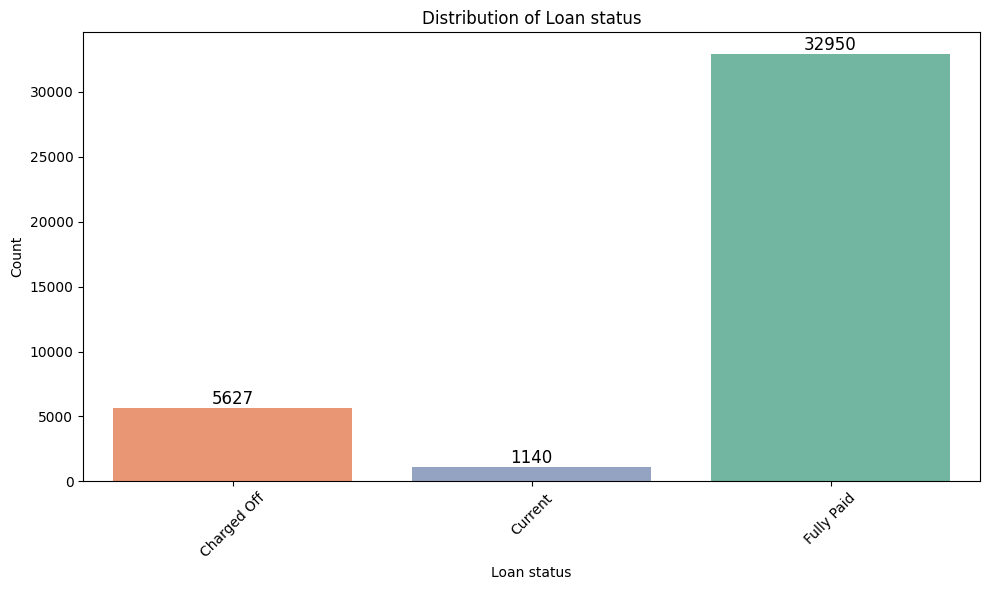

Column: pymnt_plan
pymnt_plan
n    39717
Name: count, dtype: int64



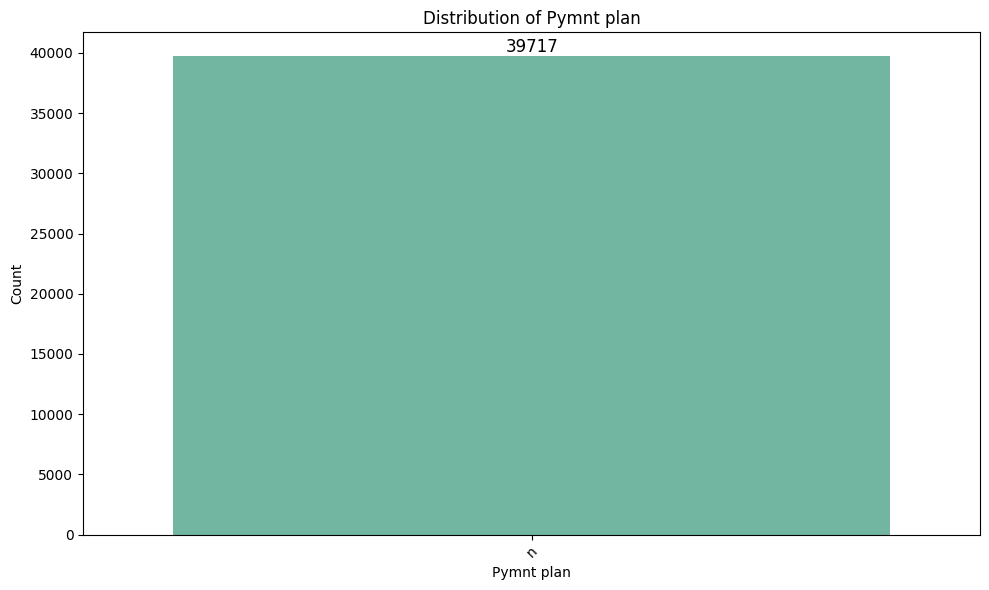

Column: purpose
purpose
debt_consolidation    18641
credit_card            5130
other                  3993
home_improvement       2976
major_purchase         2187
small_business         1828
car                    1549
wedding                 947
medical                 693
moving                  583
vacation                381
house                   381
educational             325
renewable_energy        103
Name: count, dtype: int64



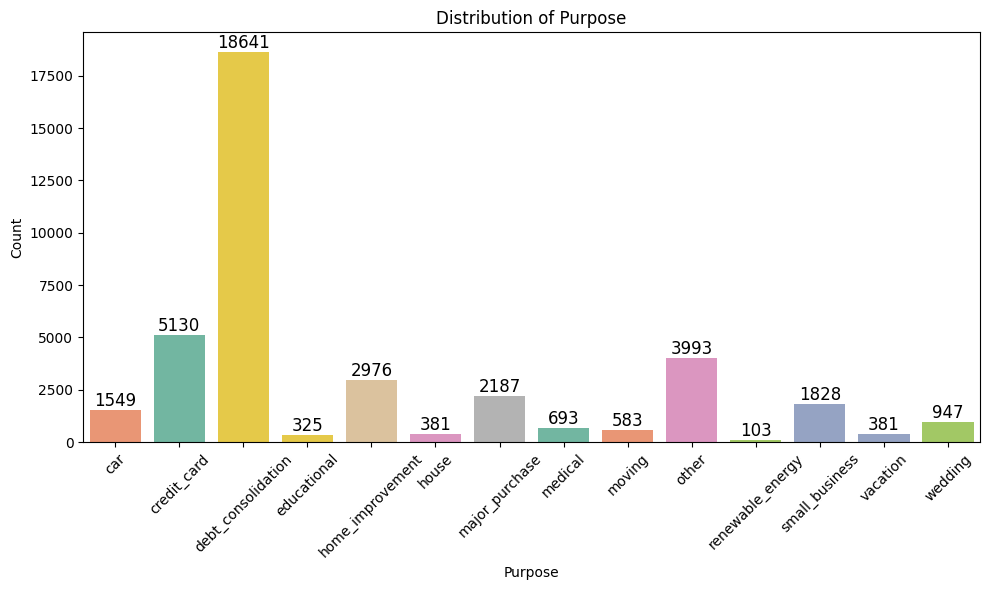

Column: title
title
Debt Consolidation            2195
Debt Consolidation Loan       1729
Personal Loan                  659
Consolidation                  517
debt consolidation             505
                              ... 
hardwood flooring business       1
DebtFix                          1
Credit card repayment loan       1
Brown Eyes Loan                  1
citicard fund                    1
Name: count, Length: 19615, dtype: int64

Column: addr_state
addr_state
CA    7099
NY    3812
FL    2866
TX    2727
NJ    1850
IL    1525
PA    1517
VA    1407
GA    1398
MA    1340
OH    1223
MD    1049
AZ     879
WA     840
CO     792
NC     788
CT     751
MI     720
MO     686
MN     615
NV     497
SC     472
WI     460
AL     452
OR     451
LA     436
KY     325
OK     299
KS     271
UT     258
AR     245
DC     214
RI     198
NM     189
WV     177
HI     174
NH     171
DE     114
MT      85
WY      83
AK      80
SD      64
VT      54
MS      19
TN      17
IN       9
ID       6
IA    

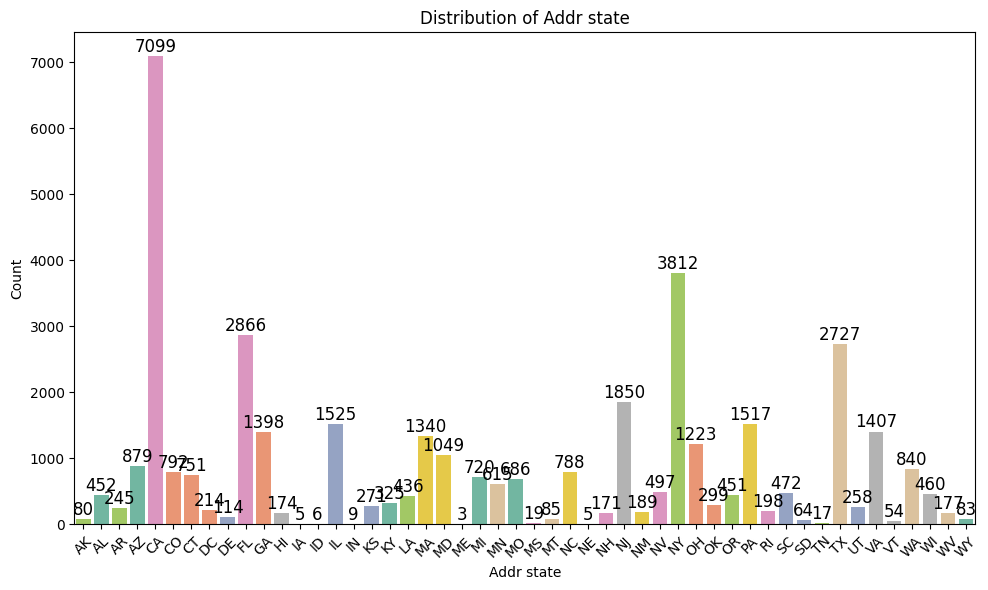

Column: initial_list_status
initial_list_status
f    39717
Name: count, dtype: int64



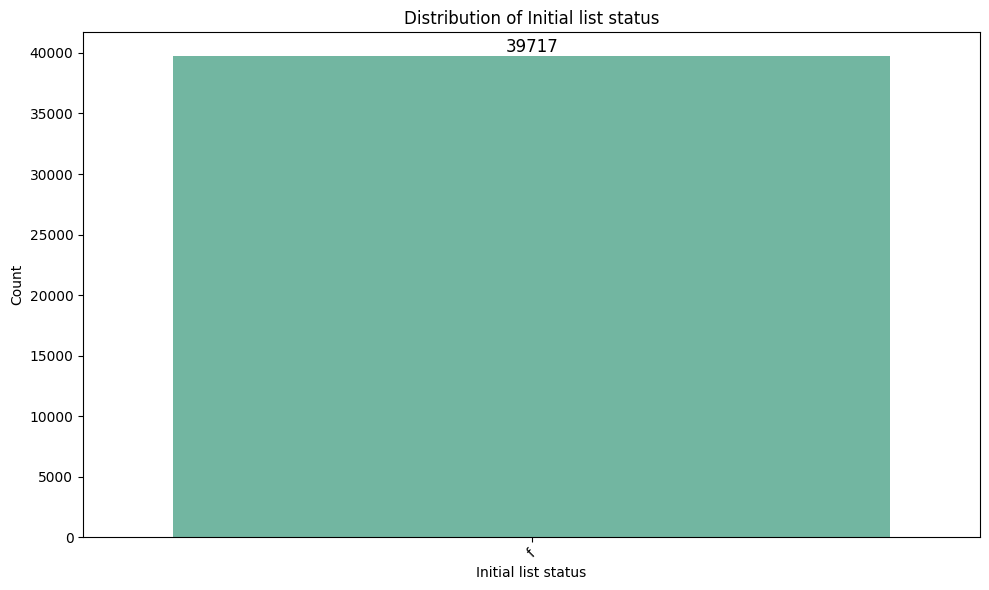

Column: application_type
application_type
INDIVIDUAL    39717
Name: count, dtype: int64



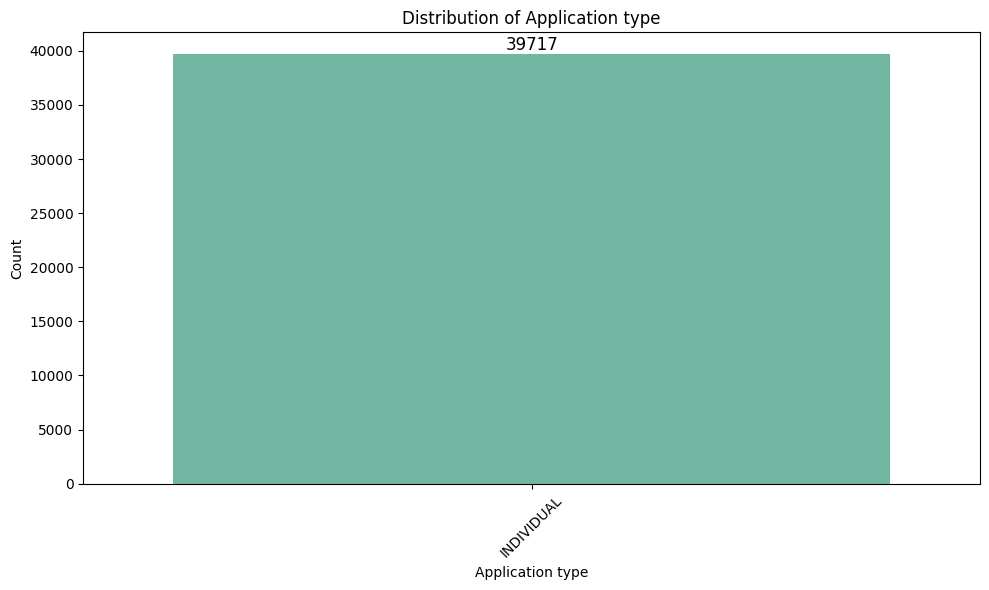

In [20]:
# Analyze and visualize categorical variables with minimal color scheme
for categorical_col in categorical_cols:
    print(f"Column: {categorical_col}")
    print(loan_clean_df[categorical_col].value_counts())
    print()
    
    if categorical_col in ['emp_title', 'title']: continue
    
    visualize_distribution_minimal(loan_clean_df, categorical_col)
    

In [21]:
# Dropping the unnecessary columns
columns_to_drop = columns_to_drop + ['application_type', 'initial_list_status', 'pymnt_plan'] # Newly added columns don't have any variability.
loan_clean_df = loan_clean_df.drop(columns=filter(lambda col: col in loan_clean_df.columns, columns_to_drop))

# Making the data more consistent and potentially more informative for analysis
loan_clean_df.loc[loan_clean_df['home_ownership'] == 'NONE', 'home_ownership'] = 'OTHER'

Count of updated category: employment_experience_category
<= 5 years     15201
<= 1 year       8898
>= 10 years     8879
<= 9 years      6739
Name: count, dtype: int64


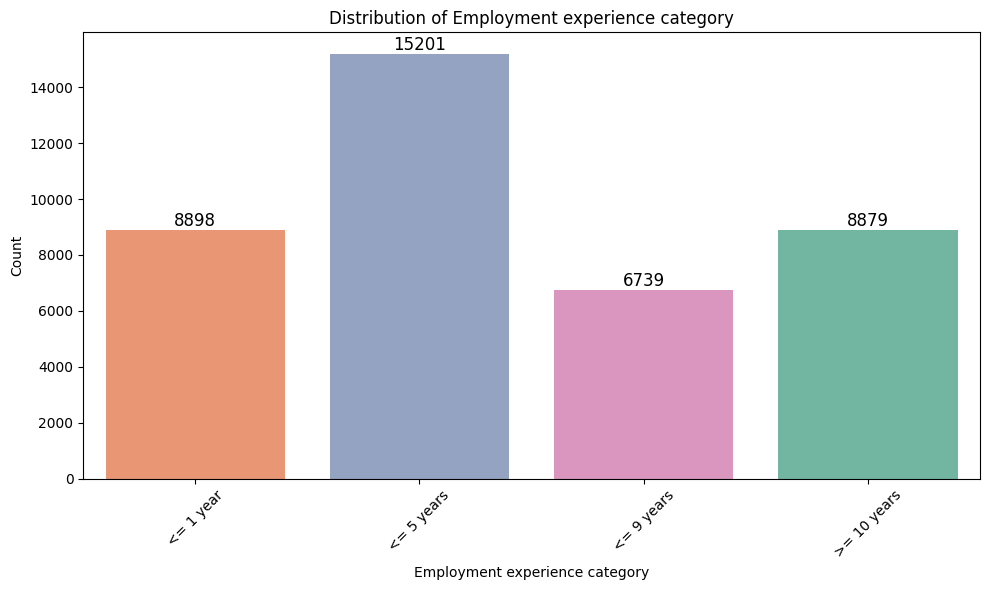

In [22]:
# Categorize employment length into more meaningful categories
loan_clean_df['employment_experience_category'] =  loan_clean_df['emp_length'].apply(categorize_emp_length)

# Validating of any other new category
print("Count of updated category:", loan_clean_df['employment_experience_category'].value_counts())
visualize_distribution_minimal(loan_clean_df, 'employment_experience_category')


Distribution of Employment Categories:
emp_profession_category
company          12522
government       10015
unknown           6622
financial         2957
telecom           2909
healthcare        1834
retail            1520
university         957
self employed      181
aerospace          161
unemployed          39
Name: count, dtype: int64

Top 50 Employment Category 'Other' Categories:
emp_title
Unknown                    2459
3M                            7
John Hancock                  5
Covidien                      5
Iron Mountain                 5
Red Lobster                   5
Mercer                        5
Massage Envy                  5
Lending Club                  5
Spherion                      4
Webtrends                     4
BP                            4
Markit                        4
Law Firm                      4
Paychex                       4
tire kingdom                  4
24 Hour Fitness               4
John Deere                    4
Baker Hughes           

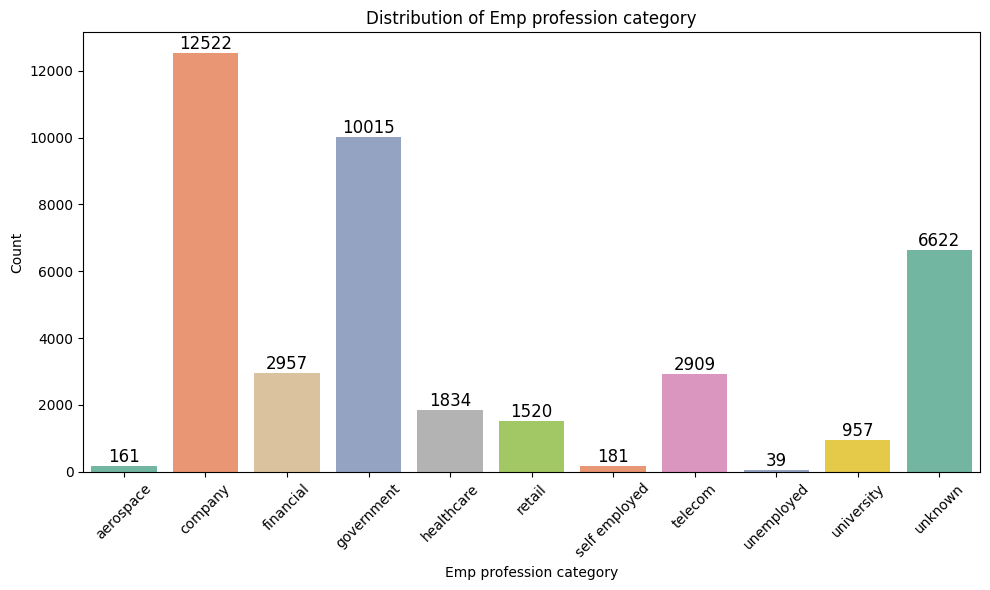

In [23]:
# Apply the categorization function to the 'emp_title' column
# Categorize the employer titles into meaningful categories
loan_clean_df['emp_profession_category'] = loan_clean_df['emp_title'].apply(categorize_employer)

# Print the distribution of categories
print("\nDistribution of Employment Categories:")
print(loan_clean_df['emp_profession_category'].value_counts())

# Analyze 'Other' category to identify potential improvements
print("\nTop 50 Employment Category 'Other' Categories:")
print(loan_clean_df[loan_clean_df['emp_profession_category'] == 'unknown']['emp_title'].value_counts().head(50))

# Visualize the distribution of employment categories
visualize_distribution_minimal(loan_clean_df, 'emp_profession_category')


In [24]:
# Basic info about the dataset
print("Dataset Info:")
loan_clean_df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 42 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   loan_amnt                       39717 non-null  int64         
 1   funded_amnt                     39717 non-null  int64         
 2   funded_amnt_inv                 39717 non-null  float64       
 3   term                            39717 non-null  int64         
 4   int_rate                        39717 non-null  float64       
 5   installment                     39717 non-null  float64       
 6   grade                           39717 non-null  object        
 7   sub_grade                       39717 non-null  object        
 8   emp_title                       39717 non-null  object        
 9   emp_length                      39717 non-null  object        
 10  home_ownership                  39717 non-null  object  

In [25]:
# Basic descriptive statistics for numeric columns
print("\nDescriptive Statistics:")
display(loan_clean_df.describe())


Descriptive Statistics:


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,issue_d,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
count,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717,39717.000000,39717.000000,39717,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717.000000,39717,39717.000000,39717,39717.000000
mean,11219.443815,10947.713196,10397.448868,42.418007,12.021177,324.561922,6.896893e+04,2010-11-03 23:26:45.166553344,13.315130,0.146512,1997-04-11 16:09:21.250849664,0.869200,9.294408,0.055065,13382.528086,48.832741,22.088828,51.227887,50.989768,12153.596544,11567.149118,9793.348813,2263.663172,1.363015,95.221624,12.406112,2013-04-17 18:42:40.978925568,2678.826162,2014-09-07 23:44:57.212780544,0.042501
min,500.000000,500.000000,0.000000,36.000000,5.420000,15.690000,4.000000e+03,2007-06-01 00:00:00,0.000000,0.000000,1969-02-01 00:00:00,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2008-01-01 00:00:00,0.000000,2007-05-01 00:00:00,0.000000
25%,5500.000000,5400.000000,5000.000000,36.000000,9.250000,167.020000,4.040400e+04,2010-05-01 00:00:00,8.170000,0.000000,1993-12-01 00:00:00,0.000000,6.000000,0.000000,3703.000000,25.500000,13.000000,0.000000,0.000000,5576.930000,5112.310000,4600.000000,662.180000,0.000000,0.000000,0.000000,2012-04-01 00:00:00,218.680000,2013-06-01 00:00:00,0.000000
50%,10000.000000,9600.000000,8975.000000,36.000000,11.860000,280.220000,5.900000e+04,2011-02-01 00:00:00,13.400000,0.000000,1998-05-01 00:00:00,1.000000,9.000000,0.000000,8850.000000,49.300000,20.000000,0.000000,0.000000,9899.640319,9287.150000,8000.000000,1348.910000,0.000000,0.000000,0.000000,2013-04-01 00:00:00,546.140000,2015-03-01 00:00:00,0.000000
75%,15000.000000,15000.000000,14400.000000,60.000000,14.590000,430.780000,8.230000e+04,2011-08-01 00:00:00,18.600000,0.000000,2001-09-01 00:00:00,1.000000,12.000000,0.000000,17058.000000,72.300000,29.000000,0.000000,0.000000,16534.433040,15798.810000,13653.260000,2833.400000,0.000000,0.000000,0.000000,2014-06-01 00:00:00,3293.160000,2016-05-01 00:00:00,0.000000
max,35000.000000,35000.000000,35000.000000,60.000000,24.590000,1305.190000,6.000000e+06,2011-12-01 00:00:00,29.990000,11.000000,2068-12-01 00:00:00,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000,6311.470000,6307.370000,58563.679930,58563.680000,35000.020000,23563.680000,180.200000,29623.350000,7002.190000,2024-11-01 00:00:00,36115.200000,2024-11-01 00:00:00,2.000000
std,7456.670694,7187.238670,7128.450439,10.622815,3.724825,208.874874,6.379377e+04,NaN,6.678594,0.491812,NaN,1.070219,4.400282,0.237200,15885.016641,28.314798,11.401709,375.172839,373.824457,9042.040766,8942.672613,7065.522127,2608.111964,7.289979,688.744771,148.671593,NaN,4447.136012,NaN,0.202603
